# 4. Model Training & XAI (Entrenamiento y Explicabilidad)

**Objetivo:** Entrenar un modelo clasificador (XGBoost) para distinguir entre texto Humano y generado por IA, y utilizar la teoría de Juegos (SHAP Values) para explicar las decisiones del modelo.

**Referencias Teóricas:**
* Se utiliza **XGBoost** por su alto rendimiento en datos estructurados.
* Se aplica **SHAP (SHapley Additive exPlanations)** para descomponer la predicción y entender la contribución marginal de cada característica lingüística (Varianza, Riqueza léxica, etc.).

## 4.1. Configuración e Importaciones

In [4]:
# Instalación de librerías si no están presentes
#%pip install xgboost shap 

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import shap
import matplotlib.pyplot as plt
import joblib
import os

# Configuración para que los gráficos se vean bien
plt.style.use('seaborn-v0_8-whitegrid')

# Rutas
INPUT_FILE = '../data/2_processed/training_data_final.csv'
MODEL_DIR = '../models/'
MODEL_PATH = '../models/xgboost_classifier.pkl'

print("✅ Librerías cargadas y entorno configurado.")

✅ Librerías cargadas y entorno configurado.


## 4.2. Carga y Preparación de Datos

In [5]:
# 1. Cargar el dataset procesado
df = pd.read_csv(INPUT_FILE)

print(f"📂 Dataset cargado: {df.shape}")
print(f"   Distribución: {df['label'].value_counts().to_dict()} (0=Humano, 1=IA)")

# 2. Limpieza de columnas NO predictivas
# Es CRÍTICO eliminar 'original_id' y textos para evitar "Data Leakage" (trampas)
cols_to_drop = ['label', 'original_id', 'text_snippet', 'article', 'title_ref']
# Filtramos solo las que existan en el DF
cols_to_drop = [c for c in cols_to_drop if c in df.columns]

X = df.drop(cols_to_drop, axis=1)
y = df['label']

print("\n📋 Features (Características) que usará el modelo:")
print(list(X.columns))

📂 Dataset cargado: (9997, 14)
   Distribución: {0: 4999, 1: 4998} (0=Humano, 1=IA)

📋 Features (Características) que usará el modelo:
['word_count', 'avg_sentence_length', 'sent_len_std', 'lexical_diversity', 'stopword_ratio', 'adj_ratio', 'verb_ratio', 'noun_ratio', 'entity_ratio', 'sentiment_polarity', 'sentiment_subjectivity', 'reading_ease']


## 4.3. División y Entrenamiento (XGBoost)

In [6]:
# 1. Split Train/Test (80% entrenamiento, 20% test)
# stratify=y asegura que haya la misma proporción de IA/Humano en ambos grupos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"⚙️ Entrenando con {X_train.shape[0]} muestras...")

# 2. Definición del Modelo XGBClassifier
# Usamos hiperparámetros robustos para evitar overfitting
model = xgb.XGBClassifier(
    n_estimators=300,        # Número de árboles
    learning_rate=0.05,      # Paso de aprendizaje (más bajo = más preciso pero lento)
    max_depth=6,             # Profundidad máxima del árbol
    subsample=0.8,           # Usar el 80% de datos por árbol (evita overfitting)
    colsample_bytree=0.8,    # Usar el 80% de columnas por árbol
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

# 3. Entrenamiento
model.fit(X_train, y_train)

print("✅ ¡Modelo entrenado exitosamente!")

⚙️ Entrenando con 7997 muestras...


c:\Users\barco\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [13:51:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ ¡Modelo entrenado exitosamente!


## 4.4. Evaluación del Modelo

In [7]:
# Predicciones en el conjunto de Test (que el modelo nunca ha visto)
y_pred = model.predict(X_test)

# Métricas
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"\n🎯 RESULTADOS DEL MODELO:")
print(f"   Accuracy: {acc:.4f} ({(acc*100):.2f}%)")
print(f"   F1-Score: {f1:.4f}")
print("-" * 30)
print("Informe detallado:")
print(classification_report(y_test, y_pred, target_names=['Humano', 'IA']))

print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))


🎯 RESULTADOS DEL MODELO:
   Accuracy: 0.9040 (90.40%)
   F1-Score: 0.9035
------------------------------
Informe detallado:
              precision    recall  f1-score   support

      Humano       0.90      0.91      0.90      1000
          IA       0.91      0.90      0.90      1000

    accuracy                           0.90      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.90      0.90      0.90      2000

Matriz de Confusión:
[[909  91]
 [101 899]]


## 4.5. Guardado del Modelo (Para Streamlit)

In [8]:
# Guardamos el modelo entrenado para usarlo luego en la Web App
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

joblib.dump(model, MODEL_PATH)
print(f"\n💾 Modelo guardado en: {MODEL_PATH}")


💾 Modelo guardado en: ../models/xgboost_classifier.pkl


# 4.6. Sección XAI (Explainable AI)

Según la teoría del curso, usamos **SHAP Values** para entender el impacto global de cada variable.
Usaremos el `TreeExplainer`, optimizado para modelos de árboles como XGBoost.

* **Gráfico Beeswarm:** Muestra qué variables son más importantes y cómo sus valores (altos/bajos) empujan hacia la clase IA (1) o Humano (0).

## 4.6.1. SHAP Global (Beeswarm Plot)

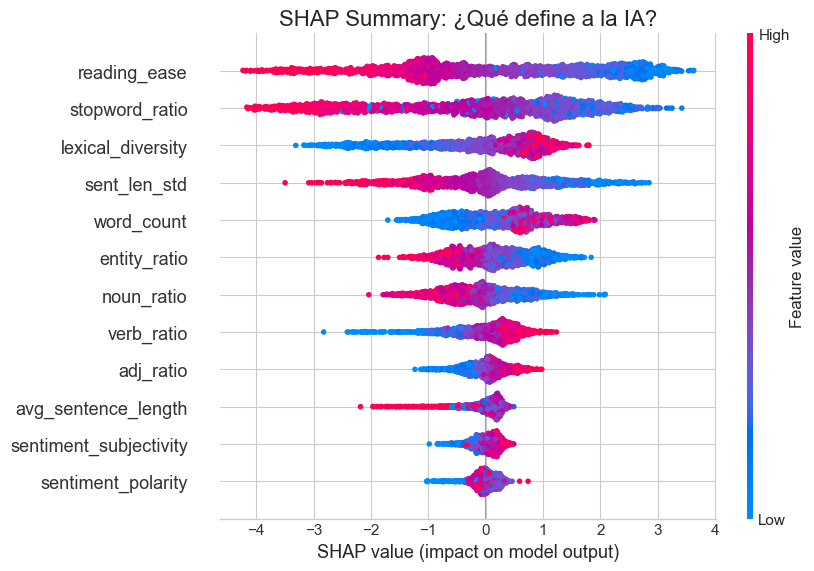

In [9]:
# 1. Crear el Explainer
explainer = shap.TreeExplainer(model)

# 2. Calcular los valores SHAP para el set de test
shap_values = explainer(X_test)

# 3. Visualización Global (Beeswarm)
plt.figure(figsize=(10, 6))
plt.title("SHAP Summary: ¿Qué define a la IA?", fontsize=16)
shap.plots.beeswarm(shap_values, max_display=12, show=True)

## 4.6.2. Explicabilidad Local (Caso de Estudio)

Analizamos una predicción específica. El **Waterfall Plot** nos muestra cómo cada característica sumó o restó probabilidad partiendo del valor base (E[f(x)]) hasta llegar a la predicción final.

🔍 Explicando predicción para la muestra índice 3 (Predicción: IA)


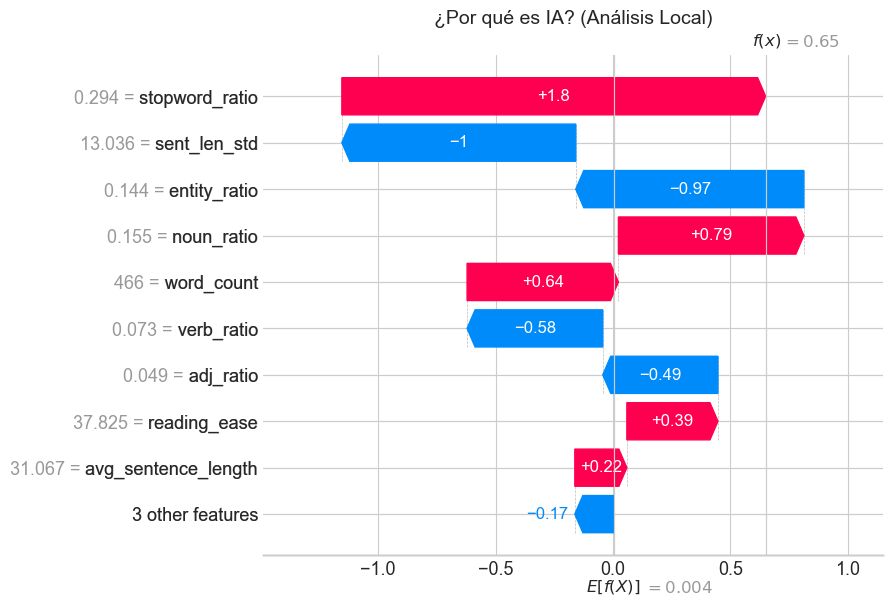

In [10]:
# Elegimos un ejemplo que el modelo haya clasificado como IA (Clase 1)
# Buscamos en y_pred dónde hay un 1
ai_indices = np.where(y_pred == 1)[0]

if len(ai_indices) > 0:
    idx_to_explain = ai_indices[0] # Cogemos el primero que encontremos
    
    print(f"🔍 Explicando predicción para la muestra índice {idx_to_explain} (Predicción: IA)")
    
    # Waterfall Plot
    plt.title(f"¿Por qué es IA? (Análisis Local)", fontsize=14)
    shap.plots.waterfall(shap_values[idx_to_explain], max_display=10, show=True)
else:
    print("No se encontraron predicciones de IA en el test set para explicar.")

## 4.6.3. Analisis automático del top 3 features

🏆 Las 3 variables más determinantes son: ['reading_ease', 'stopword_ratio', 'lexical_diversity']
----------------------------------------

🔍 Analizando a fondo: READING_EASE


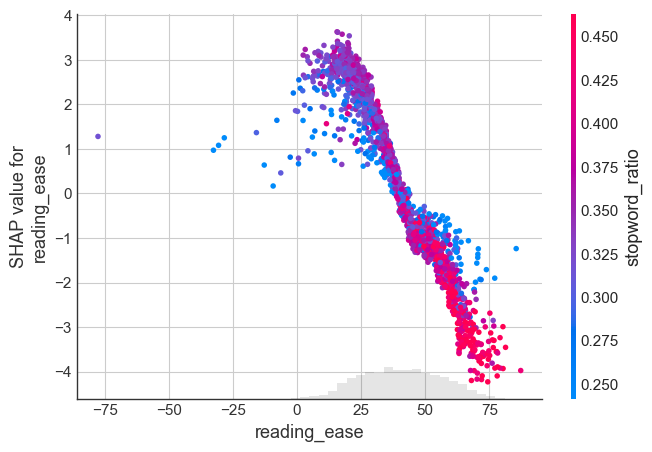

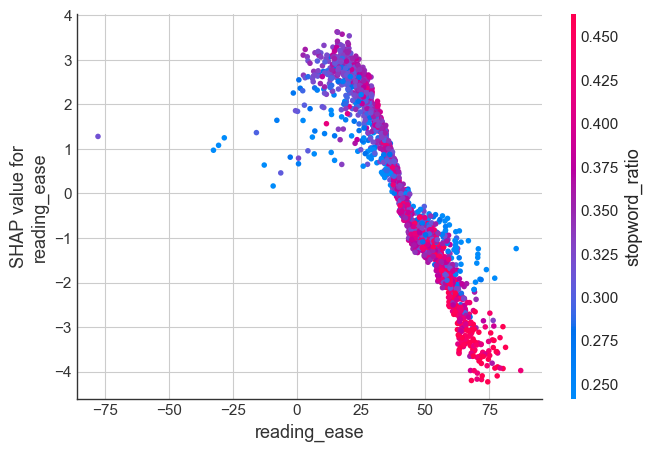


🔍 Analizando a fondo: STOPWORD_RATIO


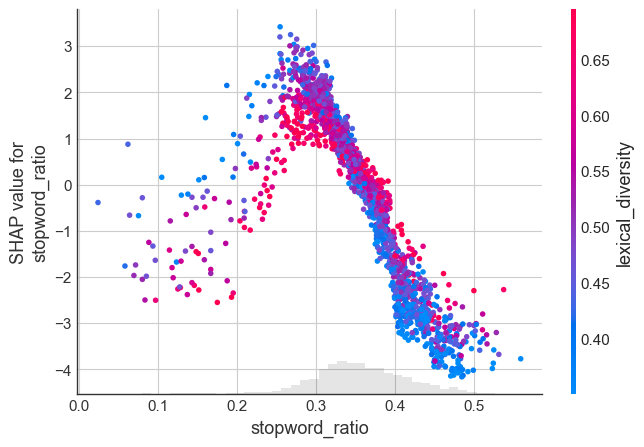

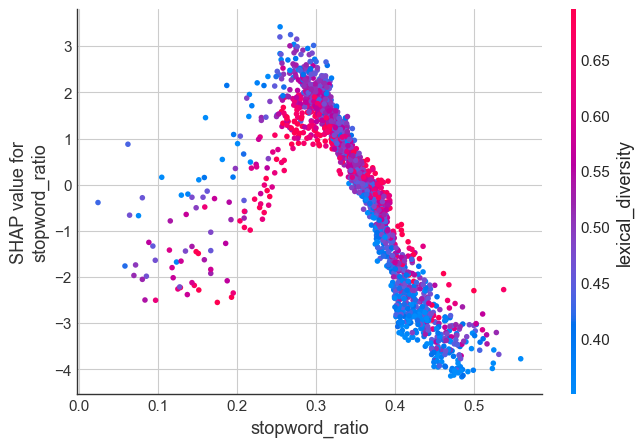


🔍 Analizando a fondo: LEXICAL_DIVERSITY


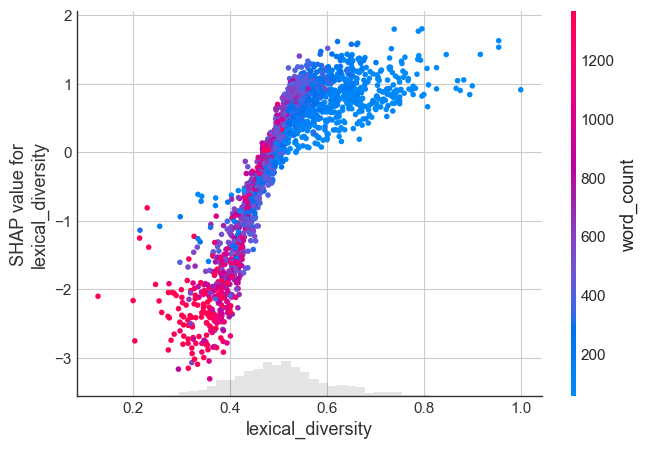

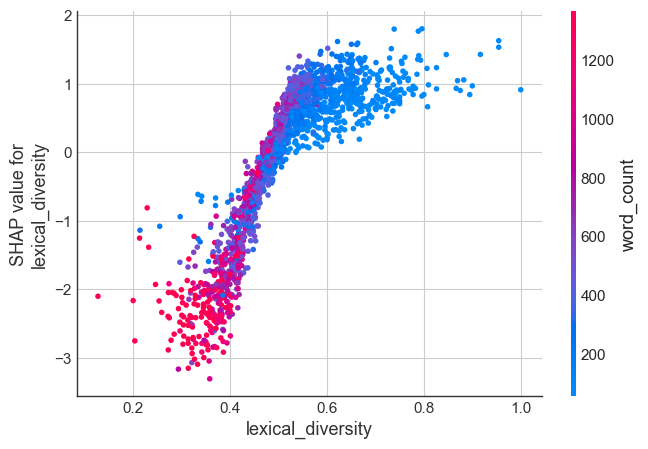

In [11]:
## 4.10. Análisis Automático del TOP 3 Características
# Objetivo: Profundizar solo en lo que realmente importa.

# 1. Obtenemos el ranking de importancia media absoluta
# (Calculamos la media de los valores SHAP absolutos para cada columna)
feature_importance = np.abs(shap_values.values).mean(0)
feature_names = X_test.columns

# Creamos un DataFrame para ordenar
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values(by='importance', ascending=False)

# Seleccionamos las 3 reinas
top_3_features = importance_df.head(3)['feature'].tolist()

print(f"🏆 Las 3 variables más determinantes son: {top_3_features}")
print("-" * 40)

# 2. Bucle para generar los gráficos clave de estas 3
for feat in top_3_features:
    print(f"\n🔍 Analizando a fondo: {feat.upper()}")
    
    # A) Gráfico de Dispersión (Scatter) - Para ver umbrales
    # Nos dice: "¿A partir de qué valor exacto esto se considera IA?"
    shap.plots.scatter(shap_values[:, feat], color=shap_values)
    
    # B) Gráfico de Dependencia (Dependence) - Para ver interacciones
    # Nos dice: "¿Cambia el efecto de esta variable si cambia otra?"
    # interaction_index='auto' busca la pareja ideal automáticamente
    shap.dependence_plot(feat, shap_values.values, X_test, interaction_index='auto')